# Outtakes

In [ ]:
# find stands touching roads
stands_touching_roads = stands[stands.geometry.intersects(roads.unary_union)]
not_touching_roads = stands[~stands['ID_UG'].isin(stands_touching_roads['ID_UG'])]
print("Stands touching roads:")
print(len(stands_touching_roads))
print("Not touching roads:")
print(len(not_touching_roads))

In [ ]:
# Create a plot to visualize the stands touching roads
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
roads.plot(ax=ax, color='black', label='Roads', alpha=0.7)

# Plot stands
stands_touching_roads.plot(ax=ax, color='green', label='Stands', alpha=0.5, edgecolor = 'grey')
not_touching_roads.plot(ax=ax, color='orange', label='Stands', alpha=0.7, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=2, label='Roads', alpha=0.7)  # Line for roads
stand_patch = mpatches.Patch(color='orange', label=f'Stands unaccessible via existing roads: {len(not_touching_roads)}', alpha=0.5)
crossed_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via existing roads: {len(stands_touching_roads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, crossed_stand_patch, stand_patch])
ax.axis('off')
# Set plot titles and labels
#plt.title('Forest Stands and Existing Roads')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Create a buffer around each road in roads then find stands touching the buffer
roads_buffered = roads.buffer(10)
stands_touching_roads = stands[stands.geometry.intersects(roads_buffered.unary_union)]
print("Stands already touching roads (with 10m buffer):")
print(len(stands_touching_roads))

In [ ]:
# subset of stands that are not accessible via timber roads yet
not_touching_roads = stands[~stands['ID_UG'].isin(stands_touching_roads['ID_UG'])]
print("Stands not touching roads:")
print(len(not_touching_roads))

In [ ]:
# Visualize 
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the roads
roads.plot(ax=ax, color='black', label='Roads', alpha=0.7)

# Plot stands
stands_touching_roads.plot(ax=ax, color='green', label='Stands', alpha=0.5, edgecolor = 'grey')
not_touching_roads.plot(ax=ax, color='orange', label='Stands', alpha=0.5, edgecolor ='grey')

# Create custom legend handles
road_line = Line2D([0], [0], color='black', lw=2, label='Roads', alpha=0.7)  # Line for roads
stand_patch = mpatches.Patch(color='orange', label=f'Stands unaccessible via existing roads: {len(not_touching_roads)}', alpha=0.5)
crossed_stand_patch = mpatches.Patch(color='green', label=f'Stands accessible via existing roads: {len(stands_touching_roads)}', alpha=0.5)

# Add the legend to the plot
ax.legend(handles=[road_line, crossed_stand_patch, stand_patch])
ax.axis('off')

# Set plot titles and labels
#plt.title('Forest Stands and Existing Roads')
#plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.show()

## Bonus to speed up: Remove unnecessary nodes

We only keep nodes with a degree greater than 2 in the graph. The information we need for the remaining nodes is just the costs associated with the segments, which will be summed up for the big edge.

To remove nodes with degree 2 while keeping the cost information intact we need to:

- Identify nodes with degree 2.
- Collapse the edges connected to these nodes, summing the associated costs. For each 2-degree node
    - retrieve its two neighbors.
    - sum the costs of the edges connected to this node.
    - remove the original edges and add a new edge directly between the two neighbors, with the summed costs.
Finally, we remove the degree-2 node itself.
- Remove the degree-2 nodes and replace their connecting edges with a single edge that has the combined cost.

62 nodes


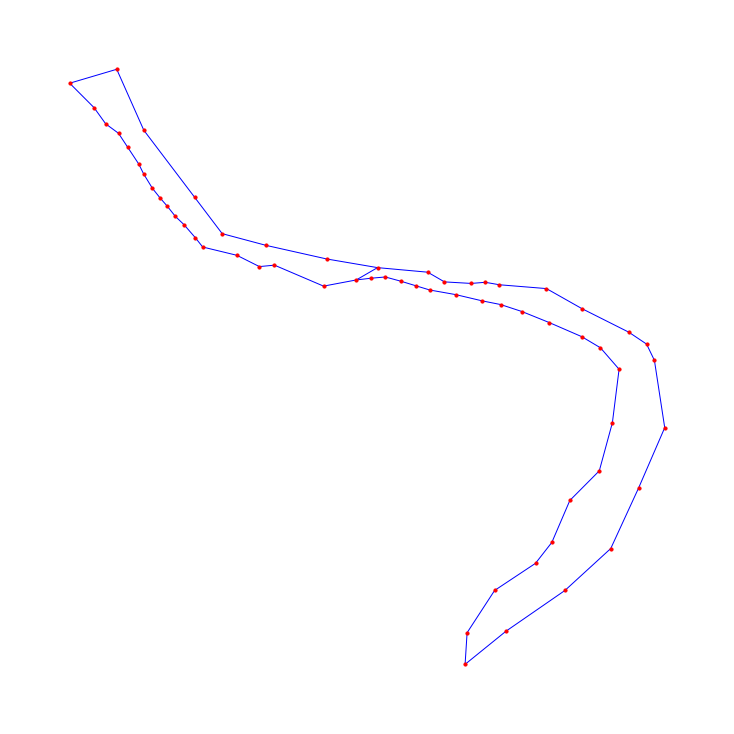

In [ ]:
# Plot the nodes
print(len(G.nodes),'nodes')
plt.figure(figsize=(10, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, node_size=10, node_color="red", edge_color="blue", with_labels=False)
plt.show()

In [ ]:
# Identify degree < or = 2
nodes_deg1 = [node for node, degree in dict(G.degree()).items() if degree == 1]
print(len(nodes_deg1),'nodes with degree 1')
nodes_deg2 = [node for node, degree in dict(G.degree()).items() if degree == 2]
print(len(nodes_deg2),'nodes with degree 2')
nodes_deg3 = [node for node, degree in dict(G.degree()).items() if degree == 3]
print(len(nodes_deg3),'nodes with degree 3')
print(len(G.nodes))

0 nodes with degree 1
60 nodes with degree 2
2 nodes with degree 3
62


In [ ]:
# remove all nodes with deg < or = 2
G_collapsed = G.copy()
G_collapsed.remove_nodes_from(nodes_deg2)
print(len(G_collapsed.nodes),'nodes remaining')

512 nodes remaining


In [ ]:
# Make a copy of the graph for manipulation
G_collapsed = G.copy()

# Identify nodes with degree ≤ 2
nodes_deg2 = [node for node in G_collapsed.nodes if G_collapsed.degree(node) <= 2]
print(len(nodes_deg2))

for node in nodes_deg2:
    # Get neighbors of the node
    neighbors = list(G_collapsed.neighbors(node))
    
    # Ensure the node has exactly 2 neighbors to collapse
    if len(neighbors) == 2:
        u, v = neighbors
        #print(f'u: {u}; v: {v}')
        

        # Sum attributes of edges (node-u and node-v)
        new_edge_data = {}
        edge_data_u = G_collapsed.get_edge_data(node, u, default={})
        #print('attributes u:', edge_data_u)
        edge_data_v = G_collapsed.get_edge_data(node, v, default={})
        #print('atributes v:', edge_data_v)
            
        # Combine attributes
        new_edge_data['edgelength'] = edge_data_u.get('edgelength') + edge_data_v.get('edgelength')
        new_edge_data['slope'] = (edge_data_u.get('slope')*edge_data_u.get('edgelength') + edge_data_v.get('slope')*edge_data_v.get('edgelength'))/new_edge_data['edgelength']
        new_edge_data['Build5m'] = edge_data_u.get('Build5m') + edge_data_v.get('Build5m')
        new_edge_data['Maintain5m'] = edge_data_u.get('Maintain5m') + edge_data_v.get('Maintain5m')
            
        #print('new_edge_data:', new_edge_data)
            
        # Add the new edge with combined attributes
        G_collapsed.add_edge(u, v, **new_edge_data)
    
    # Remove the node after processing
    G_collapsed.remove_node(node)

print(f"Number of nodes in the collapsed graph: {len(G_collapsed)}")


96
Number of nodes in the collapsed graph: 1


In [ ]:
# Iterate through all edges and print attributes for those connected by nodes with degree > 2
print("Edge attributes for edges connected to nodes with degree > 2:")
for u, v, data in G_collapsed.edges(data=True):
     #if G.degree(u) > 2 and G.degree(v) > 2:
        print(f"Edge ({u}, {v}): {data}")

Edge attributes for edges connected to nodes with degree > 2:
Edge ((-13709.983099999838, 143933.88749999925), (-13699.401100000367, 143982.4838999994)): {'edgelength': 49.735186909911846, 'slope': 6.615034956959874, 'Build5m': 240258.55257617813, 'Maintain5m': 93422.57509157842}
Edge ((-13709.983099999838, 143933.88749999925), (-13786.905700000003, 143855.29450000077)): {'edgelength': 111.65962307209116, 'slope': 15.999772953284282, 'Maintain5m': 209741.43597861606, 'Build5m': 539400.3941132429}
Edge ((-13709.983099999838, 143933.88749999925), (-13385.169599999674, 143726.66530000046)): {'edgelength': 447.34031531927275, 'slope': 37.00952284070535, 'Maintain5m': 715418.8468876218, 'Build5m': 1749101.7048801302}
Edge ((-14578.566399999894, 144321.29549999908), (-14282.127399999648, 144346.61950000003)): {'edgelength': 391.34154491621535, 'slope': 29.73166500239874, 'Maintain5m': 551924.6907261942, 'Build5m': 1286252.3186374723}
Edge ((-14578.566399999894, 144321.29549999908), (-14681.5

In [ ]:
def calculate_total_attributes(G, attribute):
    return sum(data.get(attribute, 0) for u, v, data in G.edges(data=True))

original_total_length = calculate_total_attributes(G, 'edgelength')
collapsed_total_length = calculate_total_attributes(G_collapsed, 'edgelength')

print("Original total edgelength:", original_total_length)
print("Collapsed total edgelength:", collapsed_total_length)

Original total edgelength: 273932.65831828205
Collapsed total edgelength: 190066.94278149607


423


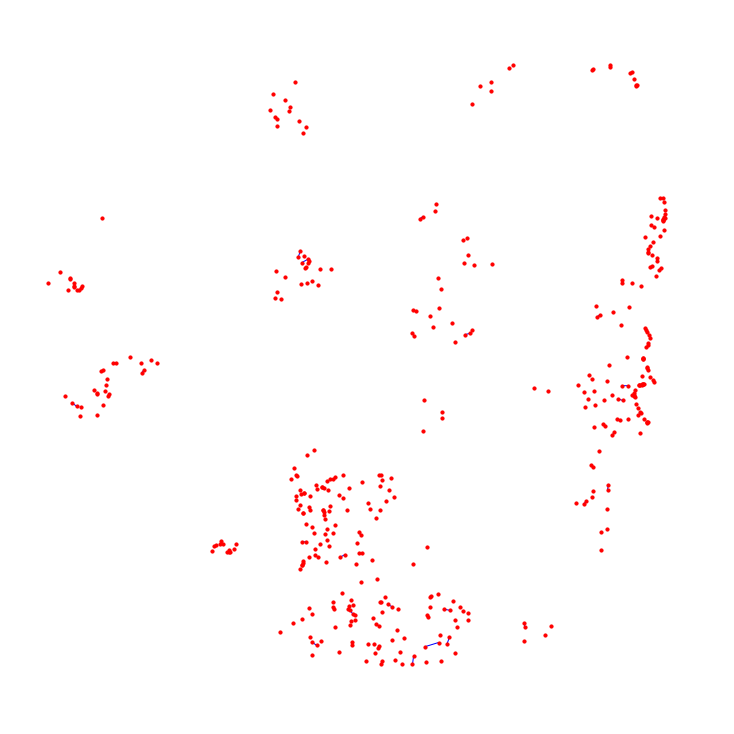

423

In [ ]:
# Plot the graph with fewer nodes
print(len(G.nodes))
plt.figure(figsize=(10, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, node_size=10, node_color="red", edge_color="blue", with_labels=False)
plt.show()
len(G.nodes)

In [ ]:
from shapely.ops import nearest_points
import numpy as np

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
# Extract vertices and edges with attributes for big graph data
list_graphdata = []

for k, df in enumerate(nonsingle_components_B_dfs):
    vertices, edges, edge_attributes = extract_boundaries_with_attributes(df)

    graphdata_B = [vertices, edges, edge_attributes]
    # Append the results to the list
    list_graphdata.append(graphdata)

    print(f'Big roads Component {k+1}')
    print(len(vertices),'vertices')
    print(len(edges), 'exterior edges')
    print(len(edge_attributes), 'edge_attributes')
    print('-------------------')
    if k==0: break

Big roads Component 1
56 vertices
71 exterior edges
71 edge_attributes
-------------------


In [ ]:
from shapely.ops import nearest_points
import numpy as np

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
# Create the bigroads graph
Gbig = nx.Graph()

# Add vertices to the graph
for vertex in big_vertices:
    Gbig.add_node(vertex)

# Add edges with attributes to the graph
for edge, attr in zip(big_exterior_edges, big_edge_attributes):
    u, v = edge
    Gbig.add_edge(u, v, **attr)

# Remove nodes that are not connected by any edges
nodes_to_remove = [node for node in Gbig.nodes if len(list(Gbig.neighbors(node))) == 0]
Gbig.remove_nodes_from(nodes_to_remove)
print(len(nodes_to_remove), 'nodes removed')

print(f"Number of vertices: {len(Gbig.nodes)}")
print(f"Number of edges: {len(Gbig.edges)}")

0 nodes removed
Number of vertices: 10483
Number of edges: 11341


In [ ]:
# old function extract boundaries but without attributes
def extract_boundaries(stands):
    vertices = []
    exterior_edges = []
    interior_edges = []

    for idx, feature in stands.iterrows():
        geometry = feature.geometry
        
        if geometry.geom_type == 'MultiPolygon':
            for poly in geometry:
                # Exterior boundary
                exterior_coords = list(poly.exterior.coords)
                vertices.extend(exterior_coords)
                exterior_edges.extend([(exterior_coords[i], exterior_coords[i+1]) for i in range(len(exterior_coords) - 1)])
                
                # Interior boundaries
                for interior in poly.interiors:
                    interior_coords = list(interior.coords)
                    vertices.extend(interior_coords)
                    interior_edges.extend([(interior_coords[i], interior_coords[i+1]) for i in range(len(interior_coords) - 1)])
        
        elif geometry.geom_type == 'Polygon':
            # Exterior boundary
            exterior_coords = list(geometry.exterior.coords)
            vertices.extend(exterior_coords)
            exterior_edges.extend([(exterior_coords[i], exterior_coords[i+1]) for i in range(len(exterior_coords) - 1)])
            
            # Interior boundaries
            for interior in geometry.interiors:
                interior_coords = list(interior.coords)
                vertices.extend(interior_coords)
                interior_edges.extend([(interior_coords[i], interior_coords[i+1]) for i in range(len(interior_coords) - 1)])
    
    # Remove duplicate vertices
    vertices = list(set(vertices))

    return vertices, exterior_edges, interior_edges

In [ ]:
from shapely.geometry import Point, LineString

def save_graph_to_shapefiles(vertices, edges, edge_attributes, output_path_points, output_path_lines):
    # Convert vertices to Point geometries for nodes
    nodes_gdf = gpd.GeoDataFrame(geometry=[Point(v) for v in vertices])
    nodes_gdf['node_id'] = range(len(vertices))  # Optional: Unique ID for each node

    # Convert edges to LineString geometries directly
    lines = [LineString([u, v]) for (u, v) in edges]  # Here `u` and `v` are coordinates, not indices
    edges_gdf = gpd.GeoDataFrame(geometry=lines)
    
    # Add edge attributes to GeoDataFrame
    edges_gdf = edges_gdf.assign(**{k: [attr[k] for attr in edge_attributes] for k in edge_attributes[0]})

    # Save to shapefiles
    nodes_gdf.to_file(output_path_points, driver="ESRI Shapefile")
    edges_gdf.to_file(output_path_lines, driver="ESRI Shapefile")


In [ ]:
save_graph_to_shapefiles(vertices, exterior_edges, edge_attributes, "points.shp", "lines.shp")

In [ ]:
from shapely.ops import nearest_points

def merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold):
    # Re-index the nodes with a spatial index for fast lookup
    nodes_sindex = nodes_gdf.sindex
    
    # Track nodes that need to be merged
    merge_dict = {}
    
    for idx, node in nodes_gdf.iterrows():
        node_geom = node.geometry
        possible_matches_index = list(nodes_sindex.intersection(node_geom.buffer(distance_threshold).bounds))
        possible_matches = nodes_gdf.iloc[possible_matches_index]
        
        for _, match in possible_matches.iterrows():
            if node_geom.distance(match.geometry) < distance_threshold and node['node_id'] != match['node_id']:
                # Choose one node to keep and update edges accordingly
                merge_dict[match['node_id']] = node['node_id']

    # Update edges to refer to merged nodes and recalculate attributes
    for edge_idx, (u, v) in enumerate(edges):
        # Check if u or v needs to be merged
        u_new = merge_dict.get(u, u)
        v_new = merge_dict.get(v, v)

        # Reassign merged node IDs and recalculate edge length and slope if nodes were merged
        if u != u_new or v != v_new:
            edges[edge_idx] = (u_new, v_new)
            edge_length = vertices[u_new].distance(vertices[v_new])
            slope = edge_attributes[edge_idx]['slope'] * edge_length / edge_attributes[edge_idx]['edgelength'] if edge_attributes[edge_idx]['edgelength'] else 0
            edge_attributes[edge_idx] = {'edgelength': edge_length, 'slope': slope}

    return nodes_gdf.drop(merge_dict.keys())  # Drop merged nodes from the GeoDataFrame

# Example usage:
# merge_close_nodes(nodes_gdf, edges_gdf, distance_threshold=0.01)


In [ ]:
merge_close_nodes(vertices, exterior_edges, distance_threshold=10)

AttributeError: 'list' object has no attribute 'sindex'

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString

def save_graph_to_shapefiles(vertices, edges, edge_attributes, output_path_points, output_path_lines):
    # Convert nodes to points with GeoDataFrame
    nodes_gdf = gpd.GeoDataFrame(geometry=[Point(v) for v in vertices])
    nodes_gdf['node_id'] = range(len(vertices))  # Optional: Unique ID for each node

    # Convert edges to lines with GeoDataFrame
    lines = [LineString([vertices[u], vertices[v]]) for (u, v) in edges]
    edges_gdf = gpd.GeoDataFrame(geometry=lines)
    
    # Add edge attributes to GeoDataFrame
    edges_gdf = edges_gdf.assign(**{k: [attr[k] for attr in edge_attributes] for k in edge_attributes[0]})

    # Save to shapefiles
    nodes_gdf.to_file(output_path_points, driver="ESRI Shapefile")
    edges_gdf.to_file(output_path_lines, driver="ESRI Shapefile")
